In [1]:
import random
import numpy as np

import torch
import torch.nn as nn

import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import KMNIST
from torch.utils.data import DataLoader

from tqdm.notebook import tqdm, trange

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True


OUTPUT_DIM = 10 
EPOCH_NUM = 7

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
train_transform = transforms.Compose([
    # transforms.Pad(4),
    # transforms.RandomCrop(28),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1))
])

In [3]:
train_dataset = KMNIST(
    root='./data/train',
    train=True, 
    transform=train_transform,
    download=True
)

test_dataset = KMNIST(
    root='./data/test',
    train=False, 
    transform=test_transform,
    download=True
)

In [4]:
dataloaders = {
    'train': DataLoader(
        dataset=train_dataset,
        batch_size=128, 
        shuffle=True
    ),
    'val': DataLoader(
        dataset=test_dataset,
        batch_size=128, 
        shuffle=False
    )
}

In [5]:
from torchvision.models import efficientnet_b7

class KMnistClassifier(nn.Module):
    def __init__(self, ouput_dim):
        super(KMnistClassifier, self).__init__()
        self.model = efficientnet_b7(pretrained=True)
        
        for param in self.model.parameters():
            param.requires_grad = False

        self.fc1 = nn.Sequential(
            nn.Linear(1000, 64),
            nn.ReLU()
        )
        self.fc2 = nn.Sequential(
            nn.Dropout(0.25),
            nn.Linear(64, ouput_dim)
        )
    
    def embed(self, x):
        return self.fc1(self.model(x))

    def forward(self, x):
        efficientnet_b6_out = self.embed(x)
        return self.fc2(efficientnet_b6_out)

In [6]:
DEVICE

'cuda'

In [7]:
model = KMnistClassifier(OUTPUT_DIM)
model = model.to(DEVICE)

Downloading: "https://download.pytorch.org/models/efficientnet_b7_lukemelas-dcc49843.pth" to C:\Users\georgiy/.cache\torch\hub\checkpoints\efficientnet_b7_lukemelas-dcc49843.pth


  0%|          | 0.00/255M [00:00<?, ?B/s]

In [8]:
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), amsgrad=True, lr=1e-4)

In [9]:
loss_hist = {'train': [], 'val': []}
acc_hist = {'train': [], 'val': []}

EPOCH_NUM = 10

for epoch in trange(EPOCH_NUM, desc='Whole pipeline'):    
    for phase in ['train', 'val']:
        dataloader = dataloaders[phase]
        
        if phase == 'train':
            model.train() 
        elif phase == 'val':
            model.eval()
        
        running_loss = 0.
        running_acc = 0.
        
        for (X_batch, y_batch) in tqdm(dataloader, desc=f'Epoch: {epoch + 1}. Phase: {phase}'):
            X_batch = X_batch / 255
            X_batch = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(X_batch)
            
            X_batch = X_batch.to(DEVICE)
            y_batch = y_batch.to(DEVICE)
            
            optimizer.zero_grad()
            
            with torch.set_grad_enabled(phase == 'train'):
                y_pred = model(X_batch)
                
                loss_value = loss_function(y_pred, y_batch)
                y_pred_class = y_pred.argmax(dim=1)
                
                if phase == 'train':
                    loss_value.backward()
                    optimizer.step()
                   
            running_loss += loss_value.item()
            running_acc += (y_pred_class == y_batch.data).float().mean().data.cpu().numpy()
        
        epoch_loss = running_loss / len(dataloader)
        epoch_acc = running_acc / len(dataloader)
        
        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} ', end='')
        
        loss_hist[phase].append(epoch_loss)
        acc_hist[phase].append(epoch_acc)

Whole pipeline:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1. Phase: train:   0%|          | 0/469 [00:00<?, ?it/s]

train Loss: 2.2191 Acc: 0.1952 

Epoch: 1. Phase: val:   0%|          | 0/79 [00:00<?, ?it/s]

val Loss: 2.4205 Acc: 0.1031 

Epoch: 2. Phase: train:   0%|          | 0/469 [00:00<?, ?it/s]

train Loss: 2.0886 Acc: 0.2609 

Epoch: 2. Phase: val:   0%|          | 0/79 [00:00<?, ?it/s]

val Loss: 2.1623 Acc: 0.2146 

Epoch: 3. Phase: train:   0%|          | 0/469 [00:00<?, ?it/s]

train Loss: 2.0485 Acc: 0.2764 

Epoch: 3. Phase: val:   0%|          | 0/79 [00:00<?, ?it/s]

val Loss: 2.0528 Acc: 0.2713 

Epoch: 4. Phase: train:   0%|          | 0/469 [00:00<?, ?it/s]

train Loss: 2.0263 Acc: 0.2853 

Epoch: 4. Phase: val:   0%|          | 0/79 [00:00<?, ?it/s]

val Loss: 2.0399 Acc: 0.2757 

Epoch: 5. Phase: train:   0%|          | 0/469 [00:00<?, ?it/s]

train Loss: 2.0105 Acc: 0.2927 

Epoch: 5. Phase: val:   0%|          | 0/79 [00:00<?, ?it/s]

val Loss: 2.0247 Acc: 0.2844 

Epoch: 6. Phase: train:   0%|          | 0/469 [00:00<?, ?it/s]

train Loss: 1.9983 Acc: 0.2960 

Epoch: 6. Phase: val:   0%|          | 0/79 [00:00<?, ?it/s]

val Loss: 2.0138 Acc: 0.2923 

Epoch: 7. Phase: train:   0%|          | 0/469 [00:00<?, ?it/s]

train Loss: 1.9865 Acc: 0.3026 

Epoch: 7. Phase: val:   0%|          | 0/79 [00:00<?, ?it/s]

val Loss: 2.0060 Acc: 0.2923 

Epoch: 8. Phase: train:   0%|          | 0/469 [00:00<?, ?it/s]

train Loss: 1.9876 Acc: 0.3008 

Epoch: 8. Phase: val:   0%|          | 0/79 [00:00<?, ?it/s]

val Loss: 2.0023 Acc: 0.2968 

Epoch: 9. Phase: train:   0%|          | 0/469 [00:00<?, ?it/s]

train Loss: 1.9752 Acc: 0.3037 

Epoch: 9. Phase: val:   0%|          | 0/79 [00:00<?, ?it/s]

val Loss: 1.9982 Acc: 0.2953 

Epoch: 10. Phase: train:   0%|          | 0/469 [00:00<?, ?it/s]

train Loss: 1.9752 Acc: 0.3064 

Epoch: 10. Phase: val:   0%|          | 0/79 [00:00<?, ?it/s]

val Loss: 1.9933 Acc: 0.2954 

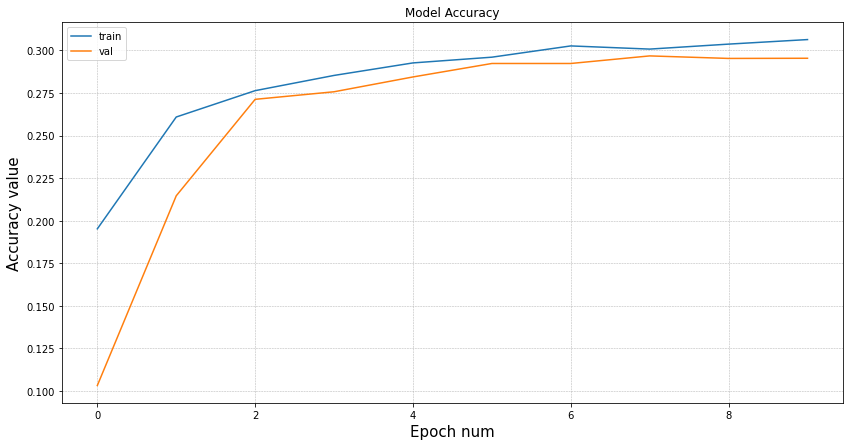

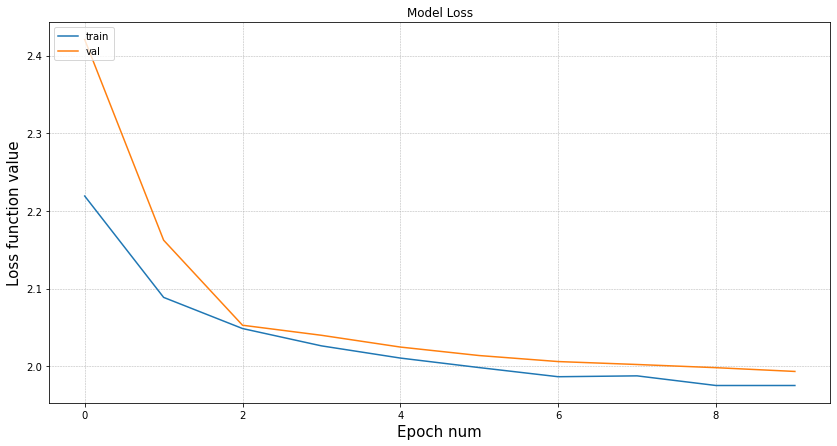

In [10]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (14, 7)
for experiment_id in acc_hist.keys():
    plt.plot(acc_hist[experiment_id], label=experiment_id)
plt.legend(loc='upper left')
plt.title('Model Accuracy')
plt.xlabel('Epoch num', fontsize=15)
plt.ylabel('Accuracy value', fontsize=15)
plt.grid(linestyle='--', linewidth=0.5, color='.7')
plt.show()

plt.rcParams['figure.figsize'] = (14, 7)
for experiment_id in loss_hist.keys():
    plt.plot(loss_hist[experiment_id], label=experiment_id)
plt.legend(loc='upper left')
plt.title('Model Loss')
plt.xlabel('Epoch num', fontsize=15)
plt.ylabel('Loss function value', fontsize=15)
plt.grid(linestyle='--', linewidth=0.5, color='.7')
plt.show()

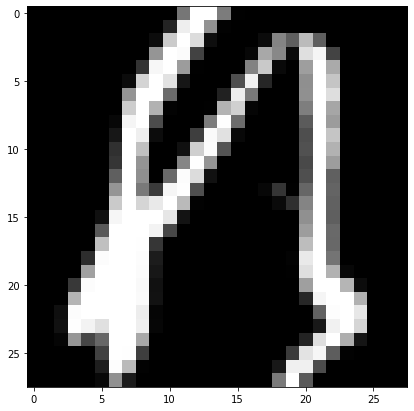

In [11]:
img = train_dataset[0][0].detach().numpy()

plt.imshow(np.transpose(img, (1,2,0)))

In [12]:
len(train_dataset)

60000

In [13]:
train_items = [train_dataset[i] for i in range(1000)]
xs, ys = zip(*train_items)

xs = torch.stack(xs)
xs = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(xs)
xs.size()

torch.Size([1000, 3, 28, 28])

In [14]:
device = torch.device(DEVICE)
xss = xs.to(device)

In [15]:
embs = model.embed(xss)
embs.size()

torch.Size([1000, 64])

In [16]:
import umap

In [17]:
points = umap.UMAP().fit_transform(embs.detach().cpu().numpy())
points.shape

(1000, 2)

In [18]:
from tensorboardX import SummaryWriter

writer = SummaryWriter()

In [19]:
writer.add_embedding(embs,
                     metadata=ys,
                     label_img=xs)
writer.close()